In [1]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
from pydoc import help
from pyhdf.SD import *
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [10]:
#potential temperature application

from metpy.calc import dry_lapse, potential_temperature, moist_lapse, equivalent_potential_temperature
from metpy.units import units

plevs = [1000, 925, 850, 700] * units.hPa

drylapserate = dry_lapse(plevs, 288.15 * units.kelvin).to('kelvin')

#since the lapse rate follows the dry adiabatic lapse rate, potential temperature will be conserved
potential_temperature(plevs, drylapserate)

Magnitude,[288.15 288.15 288.15 288.15000000000003]
Units,kelvin


In [37]:
moistlapserate

Magnitude,[288.15 285.0140606315814 281.50618934942486 272.9387222167425]
Units,kelvin


below the saturation point, the LCL
as parcel goes up no condensation, the temperature will follow the dry adiabatic lapse rate

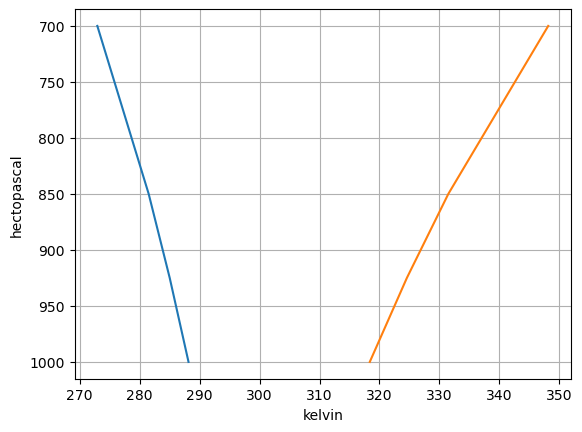

In [36]:
moistlapserate = moist_lapse(plevs, 288.15 * units.kelvin).to('kelvin')

thetae = equivalent_potential_temperature(plevs, moistlapserate, moistlapserate[0])

plt.plot(moistlapserate, plevs)
plt.plot(thetae, plevs)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [22]:
# Units: J/Kg/K
rd = 287.04 # gas constant of dry air
rv = 461.50 # gas constant of water vapor
cvd = 719. # heat capacity at constant volume for dry air
cpd = 1005.7 # heat capacity at constant pressure for dry air
cvv = 1410. # heat capacity at constant volume of water vapor
cpv = 1870. # heat capacity at constant pressure of water vapor
cl = 4190. # heat capacity of liquid water (above freezing)
cpvmcl = cl-cpv # cpvmcl seems to be a common notation for this value

# Units: dimensionless
epsilon = rd/rv

# Units: J/Kg
lv0 = 2.501E6 # latent heat of vaporization at 0-deg-C
ls = 2.834E6 # latent heat of sublimation (-100<=T<= 0-deg-C)
lf = 0.3337E6 # latent heat of fusion at 0-deg-C (lv0-ls)

# Units: m/s**2
g = 9.80665 # standard gravity

# functions
def lv(T):
    """Calculate latent heat of vaporization.
    
    Units: J/Kg.
    
    Args:
        T (double): air temperature in K.
        
    Returns:
        double: latent heat of vaporization at temperature T following Appendix 2 (p. 566-567) of Emanuel (1994).
    
    """
    return lv0 - cpvmcl*(T-273.15)

def eval_theta_e(T, q, ql, qi, p,
                          P0=1e5,
                          RD=rd,
                          RV=rv,
                          CPD=cpd,
                          CL=cl,
                          LF=lf,
                          EPS=epsilon):

    #convert inputs to proper units, forms 
    #press = press_hPa * 100. # in Pa
    T0 = 273.16; # Triple point = freezing point
    LV = lv(T);
    
    qt = q+ql+qi;
    e = p*q/( q+EPS*(1-qt) );
    es = eval_es(T)*(T>=T0)+eval_esi(T)*(T<T0);
    
    RE = (1-qt)*RD;
    R = RE + q*RV;
    
    CPL = CPD + qt*(CL-CPD);
    
    chi = RE/CPL;
    gamma = RV*q/ CPL;
    gammi = (CL-ci(T0))* qi/CPL;
    
    theta_e = T * (P0*R/p/RE)**chi* (es/e)**gamma* (T0/T)**gammi* np.exp( (q*LV/T - LF*qi/T0)/CPL )
    
    
    return theta_e



def eval_qsat(T, p, qt=0, 
              T0 = 273.16, 
              EPS=epsilon):
    """Calculate saturation specific humidity.
    
    Depending on temperature, this subroutine 
    calls eval_qs (T>273.15K) & eval_qsi (T<=273.15K).
    
    Units: kg/kg (unitless).
    
    Args:
        T (double): air temperature in K.
        p (double): air pressure in Pa.
        EPS (constant): ratio of gas constant of dry air to gas constant of water vapor.
        
    Returns:
        double: saturation specific humidity.
    """
#     if nargin==2:  #assuming condensate-free & freezing at triple point
#         T0 = 273.16
#         qsat = eval_qs(T, p)
#         qsat(T<T0) = eval_qsi(T(T<T0), p(T<T0))
#     elif nargin==3:
#         T0 = 273.16
#         qsat = eval_qs(T, p, qt)
#         qsat(T<T0) = eval_qsi(T(T<T0), p(T<T0), qt(T<T0))
#     else:
    qsat = eval_qs(T, p, qt)
    if T<T0:
        qsat = eval_qsi(T, p, qt)
    return qsat
#@njit # ~650 ns vs 800 ns with njit
def eval_qsi(T, p, qt=0,
             EPS=epsilon):
    """Calculate ice saturation specific humidity.
    
    Units: kg/kg (unitless).
    
    Args:
        T (double): air temperature in K.
        p (double): air pressure in Pa.
        EPS (constant): ratio of gas constant of dry air to gas constant of water vapor.
        
    Returns:
        double: ice saturation specific humidity.
    """
    esi = eval_esi(T)
    
#     if nargin==2: #assuming condensate-free
#         qsi = eval_q(esi,p)
#     else: #given qt (suitable for plume computations)
    qsi = eval_q(esi,p,qt)
    
    return qsi
#@njit # ~590 ns vs 730 ns with njit
def eval_qs(T, p, qt=0,EPS=epsilon):
    """Calculate saturation specific humidity with respect to liquid water.
    
    Units: kg/kg (unitless).
    
    Args:
        T (double): air temperature in K.
        p (double): air pressure in Pa.
        EPS (constant): ratio of gas constant of dry air to gas constant of water vapor.
        
    Returns:
        double: saturation specific humidity.
    """
    es = eval_es(T)
    
#     if nargin==2: #assuming condensate-free
#         qs = eval_q(es,p)
#     else: #given qt (suitable for plume computations)
    qs = eval_q(es,p,qt)
    return qs

#@njit # ~320 ns vs ~1.65 mju-s with njit
def eval_es(T):
    """Calculate saturation vapor pressure with respect to liquid water.
    
    Units: Pa.
    
    Using 2 formulae for different temperature ranges (separated by -80-deg-C).
    For T>-80-deg-C, the difference between the 2 formulae is within 0.5#.
    
    Args:
        T (double): air temperature in K.
        
    Returns:
        double: saturation vapor pressure of water (liquid).
    """
#     Tc = T-273.15
    
#     if Tc < -80.: # Is < a typo? Using Bolton
#         return eval_es_bolton(T)
#     else:
#         return 0.6105851e+03 + Tc *( 
#                0.4440316e+02 + Tc *(
#                0.1430341e+01 + Tc *( 
#                0.2641412e-01 + Tc *( 
#                0.2995057e-03 + Tc *( 
#                0.2031998e-05 + Tc *(
#                0.6936113e-08 + Tc *(
#                0.2564861e-11 - Tc * 0.3704404e-13)))))))
    es = 1e2 * np.exp( 53.67957 - 6743.769/T - 4.8451*np.log(T) );
    return es

# #@njit # ~5 mju-s vs 10 mju-s with njit
def eval_es_bolton(T):
    """Calculated saturation vapor pressure with respect to liquid water following Bolton (1980).
    
    Units: Pa.
    
    Accuracy within 0.3# for -35<T<35-deg-C.
    
    Args:
        T (double): air temperature in K.
        
    Returns:
        double: saturation vapor pressure of water (liquid).    
    """
    Tc = T-273.15
    
    return 611.2 * exp( 17.67 * Tc / (243.5+Tc) )

#@njit # ~10 mju-s vs 15 mju-s with njit
def eval_esi(T):
    """Calculate ice saturation vapor pressure.
    
    Units: Pa.
    
    Accuracy within 0.14# for -80<=T<=0-deg-C.
    
    Args:
        T (double): air temperature in K.
        
    Returns:
        double: ice saturation vapor pressure following Eq. (4.4.15) in Emanuel (1994).
    """    
    return 100. * np.exp( 23.33086 - 6111.72784/T + 0.15215*np.log(T) )






def theta_e_calc2d(T, q, p,
                          P0=1e5,
                          RD=rd,
                          RV=rv,
                          CPD=cpd,
                          CL=cl,
                          LF=lf,
                          EPS=epsilon):

    theta_e = np.zeros(q.shape)*np.nan
    # get ev in hPa 
    for a,i in enumerate(p):
        theta_e[a] = eval_theta_e(T[a],q[a],0,0,i)
        
    return theta_e

def es_calc(temp):


    #get some constants:
    tmelt  = 273.15

    #convert inputs to proper units, forms 
    tempc = temp - tmelt # in C
    tempcorig = tempc
    c=np.array((0.6105851e+03,0.4440316e+02,0.1430341e+01,0.2641412e-01,0.2995057e-03,0.2031998e-05,0.6936113e-08,0.2564861e-11,-.3704404e-13))

    #calc. es in hPa (!!!)
    #es = 6.112*EXP(17.67*tempc/(243.5+tempc))
    es=c[0]+tempc*(c[1]+tempc*(c[2]+tempc*(c[3]+tempc*(c[4]+tempc*(c[5]+tempc*(c[6]+tempc*(c[7]+tempc*c[8])))))))
    es = es#/100.

#     ;put in Bolton values for T < -80. C
#     junk = check_math(/print) ;;print out any prev. math errors
    lowtempc = np.where(tempc<-80)[0]
    es[lowtempc]=es_calc_bolton(temp[lowtempc])
    return es

def es_calc_bolton(temp):

    # ; get some constants:
    # ;pref = 100000.
    tmelt  = 273.15
    # ; convert inputs to proper units, forms 
    # ;press = press_hPa * 100. ; in Pa
    tempc = temp - tmelt # in C

    #calc. es
    es = 6.112*np.exp(17.67*tempc/(243.5+tempc))


    return es

def qs_calc(press, temp):

    #get some constants:
    tmelt  = 273.15
    RV=461.5
    RD=287.04
    EPS=RD/RV

    #convert inputs to proper units, forms 
   # press = press_hPa * 100. # in Pa
    tempc = temp - tmelt # in C

    #get es in Pa
    es = es_calc(temp)# * 100.

    #calc. qs in kg/kg
    qs = (EPS * es) / (press + ((EPS-1.)*es))
    qs = qs

    return qs

def qs_calc2d(T,p):

    #get some constants:
    tmelt  = 273.15
    RV=461.5
    RD=287.04
    EPS=RD/RV
    qs2d = np.zeros(T.shape)*np.nan
    # get ev in hPa 
    for a,i in enumerate(p):
        qs2d[a] = eval_qs(T[a],i)

    return qs2d

def eval_q(e, p, qt=0,EPS=epsilon):
    """Calculate specific humidity.
    
    Units: kg/kg (unitless).
    
    Args:
        e (double): vapor pressure in Pa.
        p (double): air pressure in Pa.
        EPS (constant): ratio of gas constant of dry air to gas constant of water vapor.
        
    Returns:
        double: specific humidity.
    """
    q = (EPS * e) / (p + ((EPS-1.)*e))

#     if nargin==2 #assuming condensate-free
#         q = EPS * e / ( p-e*(1-EPS) );
#     else #given qt (suitable for plume computations)
    #q = EPS * e * (1-qt) / (p-e)
    #q = EPS * e / ( p-e*(1-EPS) )
    return q

def ci(T):
    """Calculate heat capacity of ice.
    
    Units: J/Kg/K.
    
    Args:
        T (double): air temperature in K.
        
    Returns:
        double: heat capacity of ice at temperature T following Appendix 2 (p. 566-567) of Emanuel (1994).
    
    """
    return 2106. + 7.3*(T-273.15)

